In [1]:
#Metabolic Neural Network on single strain systems (4.3.1)

#V2: Metabolic Neural Network based on the structure of GRRANN

In [2]:
import cobra
import numpy as np
import random as rd
import math
from tensorflow.keras.layers import Layer, Lambda, Dense, Activation, BatchNormalization, Dropout, Input, concatenate
from tensorflow.keras import Model, Sequential
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
import keras.backend as K

Using TensorFlow backend.


In [3]:
def prepareNetInput(all_inps):
    inps=[]
    for ind in all_inps:
        inps.append(np.asarray(ind))
    return np.asarray(inps)

def prepareNetOutput(all_outs):
    outs=[[] for i in range(len(all_outs[0]))]
    for ifba in range(len(all_outs)):
        for ilay in range(len(all_outs[ifba])):
            outs[ilay].append(np.array(all_outs[ifba][ilay]))
    for i in range(len(all_outs[0])):
        outs[i]=np.asarray(outs[i])
    return outs

def saveInOut(netInps, netOuts, filebase, append=True):
    '''Save the input and output using pickle
    '''
    infn, outfn = filebase + '_inputs.pickle', filebase + '_outputs.pickle'
    if infn in os.listdir() or outfn in os.listdir():
        if append:
            preinp, preout = loadInOut(filebase)
            netInps = np.append(preinp,netInps,axis=0)
            for i in range(len(preout)):
                netOuts[i] = np.append(preout[i],netOuts[i],axis=0)
    with open(infn, 'wb') as handle:
        pickle.dump(netInps, handle)
    with open(outfn, 'wb') as handle:
        pickle.dump(netOuts, handle)
    return

def loadInOut(filebase):
    '''Load the input and output using pickle
    '''
    infn, outfn = filebase + '_inputs.pickle', filebase + '_outputs.pickle'
    with open(infn,'rb') as finputs:
        netInps = pickle.load(finputs)
    with open(outfn, 'rb') as foutputs:
        netOuts = pickle.load(foutputs)
    return netInps, netOuts

def reitOutputs(netOuts, nreit):
    '''Repeats the first layer of the outputs the number of times that is
    repeated in the model
    '''
    nO=[netOuts[0]]
    for i in range(nreit):
        nO.append(netOuts[0])
    nO.append(netOuts[1])
    return nO

def nonzeroidx_output(output, limit = 0.05):
    '''Find the metabolites that change for all the dataset. A metabolite is considered not to change if its values
    are 0 for more than (1-limit) proportion'''
    nonzero = limit*output.shape[0]
    nonzeros_idx=[]
    for j in range(output.shape[1]):
        cur_nonzeros = len(np.where(abs(output[:,j])>0.001)[0])
        if cur_nonzeros > nonzero and not checkEqual(output[:,j]):
            nonzeros_idx.append(j)
    return nonzeros_idx

#Normalize the outputs
def norm_outputs(outputs, incr=0):
    '''Normalize the outputs as (X-min)/(max-min)
    The range can be increased a % over the maximum and minimum so the predictions can excede the 
    dataset values'''
    mins = np.min(outputs,axis=0) - np.abs(np.min(outputs, axis=0)*incr)
    maxs = np.max(outputs,axis=0) + np.abs(np.max(outputs, axis=0)*incr)
    return (outputs-mins) / (maxs-mins), maxs, mins

def normTanhOutputs(outputs):
    '''Normalize the outputs as 2((X-min)/(max-min))-1
    In the range [-1, 1]'''
    mins = np.min(outputs,axis=0)
    maxs = np.max(outputs,axis=0)
    zero2one = (outputs-mins) / (maxs-mins)
    return 2 * zero2one - 1, maxs, mins

def norm2real(predictions,maxs,mins):
    '''Return the denormalized values of the output'''
    return predictions * (maxs-mins) + mins

def checkEqual(iterator):
    '''Check if all values in a vector are equal'''
    return len(set(iterator)) <= 1

In [4]:
def random_medium(model, mini=0.0, maxi=1000):
    '''Return a dictionary with random values for the metabolites ina  medium
    '''
    medium={}
    inputIds = get_influxesIds(model)
    for metab in inputIds:
        medium[metab] = rd.uniform(mini, maxi)
    return medium

def batch_of_FBAs_MNN(model, layers, num=100):
    '''Returns two lists with the dictionaries of mediums and fluxes
    '''
    all_mediums = []
    all_outs, all_inps = [], []
    i=0
    while i<num:
        all_mediums.append(random_medium(model))
        cur_fluxes = FBA_output_fluxes_MNN(model, all_mediums[-1], layers)
        if cur_fluxes != None:
            if i%(num/10)==0:
                print('Created {}/{}'.format(i,num))
            all_inps.append(list(all_mediums[-1].values()))
            all_outs.append(cur_fluxes)
            i+=1
    print('Created {}/{}'.format(num,num))
    return prepareNetInput(all_inps), prepareNetOutput(all_outs)

def get_fluxes(m):
    '''Return the metabolites that are exchanged in and out of the cell
    '''
    fluxes = {}
    for exch in m.exchanges:
        fluxes[exch.id] = exch.flux
    return fluxes

def FBA_output_fluxes_MNN(model, medium, layers):
    '''Returns the exchanged fluxes and the biomass with FBA
    '''
    with model:
        model.medium = medium
        biomass=model.slim_optimize()
        if math.isnan(biomass):
            return None
        
        fluxes = []
        for lay in layers:
            fluxes.append([])
            for r in lay:
                fluxes[-1].append(r.flux)
    return fluxes

def get_influxesIds(m):
    '''Returns a list with the metabolites that can be taken by the cell
    '''
    influxes = []
    for exch in m.exchanges:
        if exch.reaction.split()[-1] == '<=>':
            influxes.append(exch.id)
    if 'EX_h2o_e' in influxes:
        influxes.remove('EX_h2o_e')
    return influxes

def get_fluxesIds(m):
    '''Return the metabolites that are exchanged in and out of the cell
    '''
    fluxes = []
    for exch in m.exchanges:
        fluxes.append(exch.id)
    return fluxes

def get_inputReactions(m):
    '''Returns a list with the reactions of the metabs that can be taken by the cell
    '''
    influxes = []
    for exch in m.exchanges:
        if exch.reaction.split()[-1] == '<=>':
            if exch.id != 'EX_h2o_e':
                influxes.append(exch)
    return influxes

def get_outputReactions(m):
    '''Return the list with the reactions that are exchanged in and out of the cell
    '''
    fluxes = []
    for exch in m.exchanges:
        if exch.id != 'EX_h2o_e':
            fluxes.append(exch)
    return fluxes

def get_inputMetabs(m):
    '''Returns a list with the metabs that can be taken by the cell
    '''
    reactions = get_inputReactions(m)
    metabs=[]
    for r in reactions:
        if not 'h_e' in r.reactants[0].id:
            metabs.append(r.reactants[0])
    return metabs

def get_outputMetabs(m):
    '''Return the list with the metabs that are exchanged in and out of the cell
    '''
    reactions = get_outputReactions(m)
    metabs = []
    for r in reactions:
        metabs.append(r.reactants[0])
    return metabs

def deleteMetabolites(vector, metabs):
    '''Remove metabolites objects which ids are in the list metabs from the list vector
    '''
    for m in vector:
        if m.id in metabs:
            vector.remove(m)
    return vector

def getReactantsProducts(reaction):
    '''Return the reactants and the products of a reaction. Takes in account if the reaction
    is reversible
    '''
    notInclude = ['h_c','h_e', 'h2o_e', 'h2o_c']
    r_raw, p_raw = reaction.reactants, reaction.products
    r, p = deleteMetabolites(r_raw, notInclude), deleteMetabolites(p_raw, notInclude)
    if not '<' in reaction.reaction:
        return r, p
    else:
        return r+p, r+p

def metabolitesGraph(m):
    '''Create a graph where the nodes are the reactions.
    Graph: {metabSource:[metabsTarget]}
    '''
    graph = {}
    for reaction in m.reactions:
        reactants, products = getReactantsProducts(reaction)
        for r in reactants:
            if not r in graph:
                graph[r] = []
            for p in products:
                graph[r].append(p)

    #Adding final metabolites with no further reactions
    for met in m.metabolites:
        if met not in graph:
            graph[met]=[]
    return graph

def get_inicialReacts(m):
    '''Returns the initial reactions (the ones where the external input metabolites are included
    '''
    iReacts = []
    sourcesMetabs = get_inputMetabs(m)
    for r in m.reactions:
        if not 'EX_' in r.id:
            for met in r.reactants:
                if met in sourcesMetabs:
                    iReacts.append(r)
    return iReacts

def reactionsGraph(m):
    '''Create a graph where the nodes are the reactions.
    Graph: {reactionSource:[reactionsTarget]}
    '''
    graph = {}
    for metab in m.metabolites:
        users, producers = [], []
        for r in metab.reactions:
            reactants, products = getReactantsProducts(r)
            if metab in reactants:
                users.append(r)
            if metab in products:
                producers.append(r)
            
        for p in producers:
            if not p in graph:
                graph[p]=[]
            for u in users:
                if u!=p:
                    graph[p].append(u)
    #Adding final reactions with no further reactions
    for r in m.reactions:
        if r not in graph:
            graph[r]=[]
    return graph


In [5]:
def bfs_layers(graph, sources):
    '''Return the layers corresponding to the distance to the sources in a directed graph
    using breadth first search. #Biomass added after bigger layer.
    '''
    layers, vis = [sources],[*sources]
    layersIds=[[]]
    for s in vis:
        layersIds[0].append(s.id)

    il=0
    while len(layers[il]) > 0:
        layers.append([])
        layersIds.append([])
        for s in layers[il]:
            for t in graph[s]:
                if not t in vis:
                    vis.append(t)
                    layers[-1].append(t)
                    layersIds[-1].append(t.id)
        il+=1
    layers.pop()
    layersIds.pop()
##    longerLayer = layers.index(max(layers,key=len))
##    layers[longerLayer+1].append('Biomass')
##    layersIds[longerLayer+1].append('Biomass')
    return layers, layersIds

def grrann_layers(m):
    '''Given a cobra model, returns a list with the reactions of the model and another list
    with its exchanges and the BIOMASS reactions 
    '''
    reactions, exchanges = [], []
    reIds, exIds = [], []
    for reaction in m.reactions:
        if 'EX_' in reaction.id or 'BIOMASS' in reaction.id:
            exchanges.append(reaction)
            exIds.append(reaction.id)
        else:
            reactions.append(reaction)
            reIds.append(reaction.id)
    return [reactions, exchanges], [reIds, exIds]

In [6]:
def build_MNNv1_0(inp_medium, layers):
    '''Build an Metabolic Neural Network where where each neuron represents a reaction
    There might be extra neurons to cover some dependencies.
    The input layer covers the fluxes in the medium, then 2 extra layers are added, to
    predict the actual flux of this metabolites into the cell, which is the first metabolic layers
    '''
    ninp = len(inp_medium)
    inputLayer = Input(shape=(ninp,))
    x=Dense(ninp*3, activation='relu', name='inputLayer0')(inputLayer)
    x=Dense(ninp*3, activation='relu', name='inputLayer1')(x)
    
    mLayer0=Dense(len(layers[0])+10, activation='relu', name='mLayer0')(x)
    out0 = Lambda(lambda x: x[:,:len(layers[0])])(mLayer0)
    
    mLayer1=Dense(len(layers[1])+10, activation='relu', name='mLayer1')(mLayer0)
    mLayer2=Dense(len(layers[2])+10, activation='relu', name='mLayer2')(mLayer1)
    mLayer3=Dense(len(layers[3])+10, activation='relu', name='mLayer3')(mLayer2)
    mLayer4=Dense(len(layers[4])+10, activation='relu', name='mLayer4')(mLayer3)

    model = Model(inputs=inputLayer,
                  outputs=[out0, mLayer1, mLayer2, mLayer3, mLayer4],
                  name="metabolicnnet")
    return model

def build_MNNv1_1(inp_medium, layers):
    '''Build an Metabolic Neural Network where where each neuron represents a reaction
    There might be extra neurons to cover some dependencies.
    The input layer covers the fluxes in the medium, then 2 extra layers are added, to
    predict the actual flux of this metabolites into the cell, which is the first metabolic layers
    '''
    ninp = len(inp_medium)
    extraNeurons = 40
    
    inputLayer = Input(shape=(ninp,), name='Input_medium')
    x=Dense(ninp*4, activation='relu', name='Extra_layer1')(inputLayer)

    mnLayers=[Dense(ninp*3, activation='relu', name='Extra_layer2')(x)]
    outs, losses, wlosses = [], {}, {}
    for i in range(len(layers)):
        mnLayers.append(Dense(len(layers[i])+extraNeurons, activation='linear',
                              name='mLayer'+str(i))(mnLayers[-1]))
        losses['Output'+str(i)]='mean_squared_error'
        wlosses['Output'+str(i)]=len(layers[i])
        outs.append(Lambda(lambda x: x[:,:len(layers[i])],
                           name='Output'+str(i))(mnLayers[-1]))

    model = Model(inputs=inputLayer,
                  outputs=outs,
                  name="metabolicnnet")
    model.compile(optimizer='Adam', metrics=['mae'],
                  loss=losses, loss_weights = wlosses)
    return model

def build_MNNv2_0(inp_medium, layers, nreit, reactLossW = 0.5):
    '''Build an Metabolic Neural Network where where each neuron represents a reaction
    There might be extra neurons to cover some dependencies.
    The input layer covers the fluxes in the medium, then 2 extra layers are added, to
    predict the actual flux of this metabolites into the cell, which is the first metabolic layers
    '''
    ninp = len(inp_medium)

    #Input layer with the medium concentrations
    inputLayer = Input(shape=(ninp,), name='Input_medium')

    #Reactions layers repeated nreit times as dense layers
    outs, losses, wlosses = [], {}, {}
    mnnLayers=[Dense(len(layers[0]), activation='linear',
                     name='ReactLayer0')(inputLayer)]
    losses['ReactLayer0'] = 'mean_squared_error'
    wlosses['ReactLayer0'] = reactLossW/(nreit+1)
    outs.append(mnnLayers[-1])
    for i in range(1,nreit+1):
        mnnLayers.append(Dense(len(layers[0]), activation='tanh',
                              name='ReactLayer'+str(i))(mnnLayers[-1]))
        losses['ReactLayer'+str(i)] = 'mean_squared_error'
        wlosses['ReactLayer'+str(i)] = reactLossW/(nreit+1)
        outs.append(mnnLayers[-1])

    #Output layer with the fluxes exchanges
    outputLayer = Dense(len(layers[1]), activation='tanh',name='OutputLayer')(mnnLayers[-1])
    losses['OutputLayer'] = 'mean_squared_error'
    wlosses['OutputLayer'] = 1-reactLossW
    outs.append(outputLayer)

    model = Model(inputs=inputLayer,
                  outputs=outs,
                  name="MetabolicNeuralNetv2.0")
    model.compile(optimizer='Adam', metrics=['mae'],
                  loss=losses, loss_weights = wlosses)
    return model

In [7]:
class CustomConnected(Dense):
    '''Derivation of a Dense layer where the conexions can be specified'''
    def __init__(self,units,connections,**kwargs):
        #this is matrix A
        self.connections = connections                        
        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  

    def call(self, inputs):
        output = K.dot(inputs, self.kernel * self.connections)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

def metabsNoCompartment(metabs):
    '''Return a list with the metabolites in metabs removing the compartment (metab_comp)
    '''
    ms=[]
    for m in metabs:
        ms.append('_'.join(m.id.split('_')[:-1]))
    return ms
    
def getConnectionsMatrix(glayers):
    '''Build the sparse connections matrix for the last layer of the MNNv2
    Reactions in previous layer which use or produce the metabolite exchanged in the neuron
    of the output layer are set to 1.
    '''
    mat = np.zeros((len(glayers[0]), len(glayers[1])))
    for i in range(len(glayers[0])):
        metabs = list(glayers[0][i].metabolites.keys())
        metabs = metabsNoCompartment(metabs)
        for j in range(len(glayers[1])):
            exchangeMetabs = list(glayers[1][j].metabolites.keys())
            exchangeMetabs = metabsNoCompartment(exchangeMetabs)
            common = set(metabs).intersection(set(exchangeMetabs))
            if len(common)>0:
                mat[i,j]=1
    return mat

def conventionalNN(x_train, y_train, act='relu'):
    '''Returns a model with a conventional fully connected neural network'''  
    x_train, y_train = np.array(x_train), np.array(y_train)
    ninp, nout = x_train[0].shape[1], y_train.shape[1]
    model = Sequential()
    model.add(Dense(512, input_shape=(ninp,), activation=act))
    model.add(Dense(nout))
    
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=["accuracy",'mae'])
    return model

def build_MNNv2_1(inp_medium, layers, nreit, activs = ['relu', ''], matConnections=[], reactLossW = 0.5):
    '''Build an Metabolic Neural Network where where each neuron represents a reaction
    There might be extra neurons to cover some dependencies.
    The input layer covers the fluxes in the medium, then 2 extra layers are added, to
    predict the actual flux of this metabolites into the cell, which is the first metabolic layers
    '''
    ninp = len(inp_medium)
    if matConnections == []:
        matConnections = np.ones((len(layers[0]), len(layers[1])))

    #Input layer with the medium concentrations
    inputLayer = Input(shape=(ninp,), name='Input_medium')

    #Reactions layers repeated nreit times as dense layers
    outs, losses, wlosses = [], {}, {}
    mnnLayers=[Dense(len(layers[0]), activation = activs[0],
                     name='ReactLayer0')(inputLayer)]
    losses['ReactLayer0'] = 'mean_squared_error'
    wlosses['ReactLayer0'] = reactLossW/(nreit+1)
    outs.append(mnnLayers[-1])
    for i in range(1,nreit+1):
        mnnLayers.append(Dense(len(layers[0]), activation = activs[0],
                              name='ReactLayer'+str(i))(mnnLayers[-1]))
        losses['ReactLayer'+str(i)] = 'mean_squared_error'
        wlosses['ReactLayer'+str(i)] = reactLossW/(nreit+1)
        outs.append(mnnLayers[-1])

    #Output layer with the fluxes exchanges
    if activs[1] != '':
        outputLayer = CustomConnected(len(layers[1]), matConnections, activation = activs[1],
                                      name='OutputLayer')(mnnLayers[-1])
    else:
        outputLayer = CustomConnected(len(layers[1]), matConnections,
                                      name='OutputLayer')(mnnLayers[-1])
    losses['OutputLayer'] = 'mean_squared_error'
    wlosses['OutputLayer'] = 1-reactLossW
    outs.append(outputLayer)

    model = Model(inputs=inputLayer,
                  outputs=outs,
                  name="MetabolicNeuralNetv2.0")
    model.compile(optimizer='Adam', metrics=['mae'],
                  loss=losses, loss_weights = wlosses)
    return model

def build_MNNv2_2(inp_medium, layers, nreit, nneurons=128, activ='relu', matConnections=[], reactLossW = 0.5):
    '''Build an Metabolic Neural Network where where each neuron represents a reaction
    There might be extra neurons to cover some dependencies.
    The input layer covers the fluxes in the medium, then 2 extra layers are added, to
    predict the actual flux of this metabolites into the cell, which is the first metabolic layers
    '''
    ninp = len(inp_medium)

    #Input layer with the medium concentrations
    inputLayer = Input(shape=(ninp,), name='Input_medium')

    #Extra Dense layers
    mnnLayers=[Dense(nneurons, activation=activ)(inputLayer)]
    for i in range(1,nreit+1):
        mnnLayers.append(Dense(nneurons, activation=activ)(mnnLayers[-1]))
    
    #Reaction layer 
    outs, losses, wlosses = [], {}, {}
    rLayer=Dense(len(layers[0]), activation='relu', name='ReactLayer')(mnnLayers[-1])
    losses['ReactLayer'] = 'mean_squared_error'
    wlosses['ReactLayer'] = reactLossW
    outs.append(rLayer)

    #Output layer with the fluxes exchanges
    if matConnections == []:
        outputLayer = Dense(len(layers[1]), name='OutputLayer')(rLayer)
    else:
        outputLayer = CustomConnected(len(layers[1]), matConnections,
                                      name='OutputLayer')(rLayer)
    losses['OutputLayer'] = 'mean_squared_error'
    wlosses['OutputLayer'] = 1-reactLossW
    outs.append(outputLayer)

    model = Model(inputs=inputLayer,
                  outputs=outs,
                  name="MetabolicNeuralNetv2.0")
    model.compile(optimizer='Adam', metrics=['mae'],
                  loss=losses, loss_weights = wlosses)
    return model

In [8]:
#Layer that masks the selected neurons so their outputs become 0
class maskedActivation(Layer):
    '''Derivation of a Dense layer where the conexions can be specified'''
    def __init__(self,mask,**kwargs):
        #this is matrix A
        self.mask = mask                        
        #initalize the original Dense with all the usual arguments   
        super(maskedActivation,self).__init__(**kwargs)  

    def call(self, inputs):
        output = inputs * self.mask
        return output

def tryNet():
    inputLayer = Input(shape=(4,), name='Input_medium')
    inputReact = Input(shape=(4,))
    x=Dense(4, activation ='sigmoid')(inputLayer)
    x=maskedActivation(inputReact, name='maskedActivation')(x)
    model = Model(inputs=[inputLayer, inputReact],
                  outputs=x,
                  name="trial")
    return model

do=False
if do:
    n=tryNet()
    n.summary()

    xMed = [[1,1,1,1], [2,2,2,2], [3,3,3,3], [4,4,4,4], [5,5,5,5]]
    xMask = [[1,0,1,0], [0,0,1,0], [1,1,1,0], [1,1,1,1], [0,0,0,0]]
    outs = [[1,0,1,0],[2,0,2,0], [3,3,3,0], [4,4,4,4], [0,0,0,0]]

    n.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    n.fit([xMed, xMask], [outs])

    n.predict([xMed, xMask])

In [9]:
def crossvalidationSets(inputs, ncv, j):
    '''Retuns the training and testing subset of the set (inputs) for the ncv-folds crossvalidation
    in the iteration j'''
    n=inputs[0].shape[0]
    x_train, x_test = [], []
    for i in range(len(inputs)):
        xtrain1 = inputs[i][:int(n/ncv*j),:]
        xtrain2 = inputs[i][int(n/ncv*j+n/ncv):,:]
        xtrain12 = np.vstack([xtrain1,xtrain2])
        x_train.append(xtrain12)
        x_test.append(inputs[i][int(n/ncv*j):int(n/ncv*j+n/ncv),:])
    return x_train, x_test

def biomassIndex(glayersIds):
    '''Returns the biomass index'''
    for i in range(len(glayersIds)):
        if 'BIOMASS' in glayersIds[i]:
            return i
    
def plotRealsPreds(reals, preds):
    bins = list(range(len(reals)))
    plt.plot(bins, reals, label='Reals')
    plt.plot(bins, preds, label='Preds')
    plt.legend(loc='upper right')
    plt.show()

def divide_set(s, train_prop, val_prop):
    '''Return the set divided in training, validationa and test sets'''
    val_prop = train_prop + val_prop
    x_train, x_val, x_test = [], [], []
    for i in range(len(s)):
        x_train.append(s[i][:int(train_prop*s[i].shape[0])])
        x_val.append(s[i][int(train_prop*s[i].shape[0]):int(val_prop*s[i].shape[0])])
        x_test.append(s[i][int(val_prop*s[i].shape[0]):])
    return x_train, x_val, x_test

def shuffle_dataset(datas):
    '''Randomly shuffles the databaset inputs and outputs with the same order (their rows are shuffled)'''
    s = np.arange(datas[0].shape[0])
    np.random.shuffle(s)
    for i in range(len(datas)):
        datas[i] = datas[i][s,:]
    return datas

def mean_square_error(a,b):
    '''Mean square error between two list numpy arrays'''
    return np.square(a-b).mean()

def mean_absolute_error(a,b):
    '''Mean absolute error between two list numpy arrays'''
    return np.abs(a-b).mean()

def plot_prediction_comparison(predictions, real, metab):
    '''Plot an histogram with the real and several predicted values overlapped'''
    maxi=100
    if len(real) > maxi:
        for i in range(len(predictions)):                       
            predictions[i]=predictions[i][:maxi]
        real=real[:maxi]
    
    bins = list(range(len(real)))
    if len(predictions) == 1:                           
        x, y = zip(*sorted(zip(real, predictions[0])))
    else:
        x, y, z = zip(*sorted(zip(real, predictions[0], predictions[1])))
        plt.scatter(bins, z, alpha=0.5, label='Prediction 2')

    plt.scatter(bins, x, alpha=0.5, label='Real')
    plt.scatter(bins, y, alpha=0.5, label='Prediction 1')
    plt.legend(loc='upper left')
    plt.title('Metabolite: {}'.format(metab))
    plt.show()
    
def plot_outputMNNv1(history):
    # PLOT LOSS AND ACCURACY
    %matplotlib inline
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data sets for each training epoch
    #-----------------------------------------------------------
    loss=history.history['loss']
    epochs=range(len(loss)) # Get number of epochs

    #------------------------------------------------
    # Plot training and validation MAE per epoch
    #------------------------------------------------
    for i in history.history:
        if not 'loss' in i:
            plt.plot(epochs, history.history[i], label=i)
    
    #plt.legend(loc='upper right')
    plt.title('Losses and MAEs')
    plt.show()
    
def plot_output(history, nreit):
    # PLOT LOSS AND ACCURACY
    %matplotlib inline
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data sets for each training epoch
    #-----------------------------------------------------------
    react_mae=history.history['ReactLayer{}_mean_absolute_error'.format(nreit)]
    val_react_mae=history.history['val_ReactLayer{}_mean_absolute_error'.format(nreit)]
    out_mae=history.history['OutputLayer_mean_absolute_error']
    val_out_mae=history.history['val_OutputLayer_mean_absolute_error']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(1,len(loss)+1) # Get number of epochs

    #------------------------------------------------
    # Plot training and validation MAE per epoch
    #------------------------------------------------
    plt.plot(epochs, react_mae, 'pink', label="Reactions Training MAE")
    plt.plot(epochs, out_mae, 'c', label="Output Training MAE")
    plt.plot(epochs, val_react_mae, 'r', label="Reactions Validation MAE")
    plt.plot(epochs, val_out_mae, 'b', label="Output Validation MAE")
    plt.legend(loc='upper right')

    plt.title('Validation MAE')
    plt.grid(linestyle='dotted')
    plt.xlabel('Number of epochs')
    plt.ylabel('MAE')
    plt.show()
    
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs[1:], loss[1:], 'r', label="Loss")
    plt.plot(epochs[1:], val_loss[1:], 'b', label="Validation loss")
    plt.legend(loc='upper right')

    plt.title('Training and validation loss')
    plt.grid(linestyle='dotted')
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.show()
    
def squareShape(n):
    '''Return the 2D shapes of a line vector, making it square'''
    sq = math.sqrt(n)
    if sq == int(sq):
        return (int(sq), int(sq))
    else:
        sq = int(sq)
        if sq*(sq+1) >= n:
            return (sq+1, sq)
        else:
            return (sq+1, sq+1)

def nonExactReshape(ar, nShape, fillValue=0):
    '''Reshape a vector array into a 2D array with shape nShape, filling values with 0.
    The values are filled by rows'''
    nar = np.zeros(nShape)
    nar.fill(fillValue)
    ii=0
    for i in range(nShape[0]):
        for j in range(nShape[1]):
            nar[i,j] = ar[ii]
            ii+=1
            if ii>=len(ar):
                return nar
    
def plotHeatmap(normOutPreds, yTest, heatIdx, fillValue=0, save = None):
    '''Plot the heatmap of the real and the prediction values
    normOutPreds: array with normalized predictions
    yTest: array with normalized real values'''
    valsPred, valsReal = normOutPreds[heatIdx,:], yTest[heatIdx]
    nShape = squareShape(len(normOutPreds[heatIdx,:]))
    valsPred = nonExactReshape(valsPred, nShape, fillValue = fillValue) 
    valsReal = nonExactReshape(valsReal, nShape, fillValue = fillValue)

    fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[7,7,0.5]))
    sns.heatmap(valsPred, annot=False, linewidths=.1, cmap='seismic', cbar=False, ax=axs[0])
    sns.heatmap(valsReal, annot=False,  linewidths=.1, cmap='seismic', yticklabels=False, 
                cbar=False, ax=axs[1])
    fig.colorbar(axs[1].collections[0], cax=axs[2])
    axs[0].title.set_text('Prediction outputs')
    axs[1].title.set_text('Real outputs')
    plt.tight_layout()
    if save != None:
        plt.savefig('images/{}.png'.format(save))
    plt.show()

In [10]:
#Loading the cobra models
dataFolder = 'C:/Users/danie/Desktop/ia/tfm/red_FBA/'
dataf = 'modelsEC/'
modelBases=['coreEC','iEC042','iWFL']

models = []
for i in range(len(modelBases)):
    print('Loading: ', modelBases[i])
    models.append(cobra.io.load_json_model(dataFolder + dataf + modelBases[i] + '.json'))


Loading:  coreEC
Loading:  iEC042
Loading:  iWFL


In [ ]:
#V2

In [11]:
#Chosing 1 cobra model
mIdx = 1
mCobra = models[mIdx]
rmed2 = random_medium(mCobra)

In [12]:
#Load the dataset
filebase = '{}_MNNv2'.format(modelBases[mIdx])
print('loading: ', filebase)
create = False
nFBAs = 10000
glayers, glayersIds = grrann_layers(mCobra)
if create:
    netInps, netOuts = batch_of_FBAs_MNN(mCobra, glayers, nFBAs)
    saveInOut(netInps, netOuts, filebase, append=True)
netInps, netOuts = loadInOut(filebase)

if nFBAs < netInps.shape[0]:
    netInps = netInps[:nFBAs,:]
    netOuts[0] = netOuts[0][:nFBAs,:]
    netOuts[1] = netOuts[1][:nFBAs,:]

print('Input shape: ',netInps.shape)
print('Reactions shape: ',netOuts[0].shape)
print('Exchanges shape: ',netOuts[-1].shape)

loading:  iEC042_MNNv2
Input shape:  (10000, 24)
Reactions shape:  (10000, 2328)
Exchanges shape:  (10000, 386)


In [13]:
#Preprocess the output
#Filter the output metabolites, only predicted those with considerable change
nonzerosIdx=[[],[]]
nonzerosIdx[0] = nonzeroidx_output(netOuts[0], limit = 0.05)
nonzerosIdx[1] = nonzeroidx_output(netOuts[-1], limit = 0.05)

for i in range(2):
    netOuts[i] = netOuts[i][:,nonzerosIdx[i]]
    glayersIds[i] = np.array(glayersIds[i])[nonzerosIdx[i]]
    glayers[i] = np.array(glayers[i])[nonzerosIdx[i]]
    
inout = shuffle_dataset([netInps, *netOuts])
netInps, netOuts = inout[0], inout[1:]

print('Reactions shape: ',netOuts[0].shape)
print('Exchanges shape: ',netOuts[-1].shape)

Reactions shape:  (10000, 477)
Exchanges shape:  (10000, 25)


In [14]:
#Normalizing inputs and outputs
netInps /= 1000
outMaxs, outMins = [[],[]], [[],[]]
for i in range(2):
    netOuts[i], outMaxs[i], outMins[i] = norm_outputs(netOuts[i])

In [15]:
#Adapting the layers to the determined version
nreit=0
v=22
if v==21:
    netOuts = reitOutputs(netOuts, nreit)
matCon = getConnectionsMatrix(glayers)

In [16]:
#Scheme for the optimization of the Half Black Box architecture
actOpt = True
if actOpt:
    ncv, tncv = 10, 5
    resDic = {}
    for act in ['relu']:
        print('Activations: ', act)
        for nneu in [64, 128, 256, 512]:
            print('Number of neurons: ', nneu)
            maesOut, maesReacts = [], []
            for j in range(tncv):
                #Prepare the dataset
                print('\nIteration {} / {}'.format(j+1, tncv))
                xTrain, xTest = crossvalidationSets([netInps], ncv, j)
                yTrain, yTest = crossvalidationSets(netOuts, ncv, j)

                mnnet2 = build_MNNv2_2(rmed2, glayersIds, nreit, activ=act, nneurons=nneu, 
                                       matConnections= matCon)
                
                h = mnnet2.fit(xTrain, yTrain, epochs=10, verbose=0)

                results = mnnet2.evaluate(xTest, yTest)
                print('MAE reacts: ', results[-2])
                print('MAE output: ', results[-1])
                maesOut.append(results[-1])
                maesReacts.append(results[-2])
            print('\n')
            resDic[(act,nneu)] = [np.mean(maesReacts), np.mean(maesOut)]
    for i in resDic:
        print(i, '\t', resDic[i])

Activations:  relu
Number of neurons:  64

Iteration 1 / 5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:122 DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Instructions for updating:
Use tf.cast instead.
1000/1000 [==============================] - 0s 401us/sample - loss: 0.0202 - ReactLayer_loss: 0.0288 - OutputLayer_loss: 0.0112 - ReactLayer_mean_absolute_error: 0.0782 - OutputLayer_mean_absolute_error: 0.0633
MAE reacts:  0.078154065
MAE output:  0.0633202

Iteration 2 / 5
1000/1000 [==============================] - 0s 314us/sample - loss: 0.0176 - ReactLayer_loss: 0.0253 - OutputLayer_loss: 0.0099 - ReactLayer_mean_absolute_error: 0.0714 - OutputLayer_mean_absolute_error: 0.0613
MAE reacts:  0.071396776
MAE output:  0.061276194

Iteration 3 / 5
1000/1000 [==============================] - 0s 312us/sample - loss: 0.0162 - ReactLayer_loss: 0.0231 - OutputLayer_loss: 0.0092 - ReactLayer_mean_absolute_error: 0.0683 - OutputLayer_mean_absolute_error: 0.0594
MAE reacts:  0.0682552
MAE output:  0.059416484

Iteration 4 / 5
1000/1000 [==============================] - 0s 393us/sample - loss: 0.0231 - ReactLayer_loss: 0.0359 - OutputLayer_los

In [17]:
#Building a system example
if v==21:
    mnnet2 = build_MNNv2_1(rmed2, glayersIds, nreit)#, matConnections=matCon)
elif v==22:
    mnnet2 = build_MNNv2_2(rmed2, glayersIds, nreit, nneurons=128, matConnections=matCon)
mnnet2.summary()

C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:122 DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_medium (InputLayer)    (None, 24)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               3200      
_________________________________________________________________
ReactLayer (Dense)           (None, 477)               61533     
_________________________________________________________________
OutputLayer (CustomConnected (None, 25)                11950     
Total params: 76,683
Trainable params: 76,683
Non-trainable params: 0
_________________________________________________________________


In [18]:
#Prepare the dataset
trainProp, valProp = 0.9, 0.1
realReacts, realOuts = norm2real(netOuts[-2], outMaxs[0], outMins[0]), norm2real(netOuts[-1], outMaxs[1], outMins[1])

xTrain, xVal, xTest = divide_set([netInps], trainProp, valProp)
yTrain, yVal, yTest = divide_set(netOuts, trainProp, valProp)
ryTrain, ryVal, ryTest = divide_set([realReacts, realOuts], trainProp, valProp)

In [19]:
#Train the example system
h = mnnet2.fit(xTrain, yTrain, epochs=10, verbose=4,
              validation_data=(xVal, yVal))

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


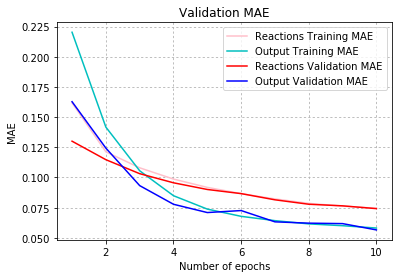

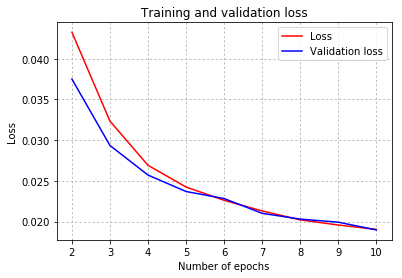

In [20]:
#Plotting the results of the example system
if v==21:
    plot_output(h, nreit)
elif v==22:
    plot_output(h, nreit='')

In [31]:
#Predictions with MNN system
results = mnnet2.evaluate(xVal, yVal)
allPreds = mnnet2.predict(xVal)
normReactPreds, normOutPreds = allPreds[-2], allPreds[-1]
reactPreds, outPreds = norm2real(normReactPreds, outMaxs[0], outMins[0]), norm2real(normOutPreds, outMaxs[1], outMins[1])

1000/1000 [==============================] - 0s 78us/sample - loss: 0.0190 - ReactLayer_loss: 0.0285 - OutputLayer_loss: 0.0093 - ReactLayer_mean_absolute_error: 0.0742 - OutputLayer_mean_absolute_error: 0.0566


In [60]:
#Comparison with the convetional neural network with the GRRANN structure
conventNN = conventionalNN(xTrain, yTrain[-1])
conventNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               12800     
_________________________________________________________________
dense_9 (Dense)              (None, 25)                12825     
Total params: 25,625
Trainable params: 25,625
Non-trainable params: 0
_________________________________________________________________


In [61]:
#Training the conevtional neural network
h = conventNN.fit(xTrain, yTrain[-1], epochs=20, verbose=4, validation_data=(xVal, yVal[-1]))

Train on 8000 samples, validate on 1000 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [63]:
#Predictions with the neural network
results = conventNN.evaluate(xTest, yTest[-1])

1000/1000 [==============================] - 0s 38us/sample - loss: 0.0086 - acc: 0.4060 - mean_absolute_error: 0.0529


In [78]:
#Optimization of the conventional NN with the GRRANN structure
actOpt = True
if actOpt:
    ncv, tncv = 10, 5
    resDic = {}
    for act in ['sigmoid','relu']:
        print('Activations: ', act)
        maesOut, maesReacts = [], []
        for j in range(tncv):
            #Prepare the dataset
            print('\nIteration {} / {}'.format(j+1, tncv))
            xTrain, xTest = crossvalidationSets([netInps], ncv, j)
            yTrain, yTest = crossvalidationSets(netOuts, ncv, j)
            
            conventNN = conventionalNN(xTrain, yTrain[-1], act=act)
            
            h = conventNN.fit(xTrain, yTrain[-1], epochs=10, verbose=0)

            results = conventNN.evaluate(xTest, yTest[-1])
            print('MAE reacts: ', results[-2])
            print('MAE output: ', results[-1])
            maesOut.append(results[-1])
            maesReacts.append(results[-2])
        resDic[(act)] = [np.mean(maesReacts), np.mean(maesOut)]
    for i in resDic:
        print(i, '\t', resDic[i])

Activations:  sigmoid

Iteration 1 / 5
1000/1000 [==============================] - 0s 269us/sample - loss: 0.0311 - acc: 0.4490 - mean_absolute_error: 0.1280
MAE reacts:  0.449
MAE output:  0.12795796

Iteration 2 / 5
1000/1000 [==============================] - 0s 302us/sample - loss: 0.0299 - acc: 0.3630 - mean_absolute_error: 0.1254
MAE reacts:  0.363
MAE output:  0.12535048

Iteration 3 / 5
1000/1000 [==============================] - 0s 303us/sample - loss: 0.0319 - acc: 0.5510 - mean_absolute_error: 0.1292
MAE reacts:  0.551
MAE output:  0.1291864

Iteration 4 / 5
1000/1000 [==============================] - 0s 313us/sample - loss: 0.0318 - acc: 0.5390 - mean_absolute_error: 0.1286
MAE reacts:  0.539
MAE output:  0.12857085

Iteration 5 / 5
1000/1000 [==============================] - 0s 323us/sample - loss: 0.0302 - acc: 0.4290 - mean_absolute_error: 0.1219
MAE reacts:  0.429
MAE output:  0.12191448
Activations:  relu

Iteration 1 / 5
1000/1000 [==============================] 

In [34]:
#Scheme for the optimization of the GRRANN-like and HBB architectures
actOpt = False
if actOpt:
    ncv, tncv = 10, 5
    resDic = {}
    for act1 in ['relu', 'sigmoid']:
        for act2 in ['sigmoid', 'relu', '']:
            print('Activations: ', act1, act2)
            maesOut, maesReacts = [], []
            for j in range(tncv):
                #Prepare the dataset
                print('\nIteration {} / {}'.format(j+1, tncv))
                xTrain, xTest = crossvalidationSets([netInps], ncv, j)
                yTrain, yTest = crossvalidationSets(netOuts, ncv, j)

                if v==21:
                    mnnet2 = build_MNNv2_1(rmed2, glayersIds, nreit, activs=[act1, act2])#, matConnections = matCon)
                elif v==22:
                    mnnet2 = build_MNNv2_2(rmed2, glayersIds, nreit, activs=[act1, act2])#, matCon)
                
                h = mnnet2.fit(xTrain, yTrain, epochs=10, verbose=0)

                results = mnnet2.evaluate(xTest, yTest)
                print('MAE reacts: ', results[-2])
                print('MAE output: ', results[-1])
                maesOut.append(results[-1])
                maesReacts.append(results[-2])
            resDic[(act1,act2)] = [np.mean(maesReacts), np.mean(maesOut)]
    for i in resDic:
        print(i, '\t', resDic[i])

In [90]:
#Predictions with the neural network
results = mnnet2.evaluate(xTest, yTest)
allPreds = mnnet2.predict(xTest)
normReactPreds, normOutPreds = allPreds[-2], allPreds[-1]
reactPreds, outPreds = norm2real(normReactPreds, outMaxs[0], outMins[0]), norm2real(normOutPreds, outMaxs[1], outMins[1])

3000/3000 [==============================] - 0s 46us/sample - loss: 0.0159 - ReactLayer0_loss: 0.0243 - OutputLayer_loss: 0.0075 - ReactLayer0_mean_absolute_error: 0.0819 - OutputLayer_mean_absolute_error: 0.0475


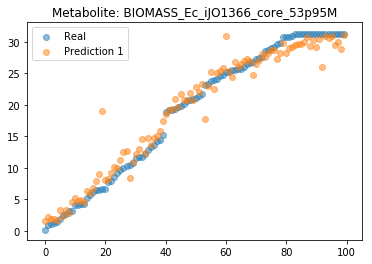

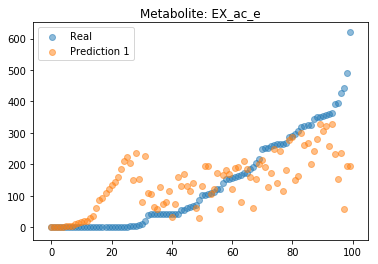

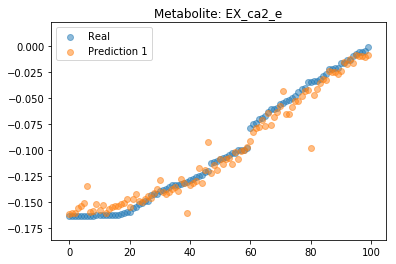

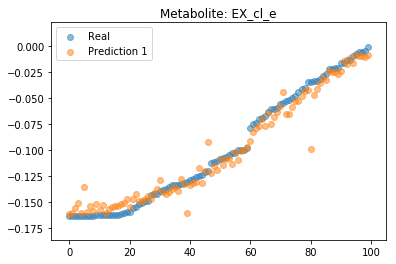

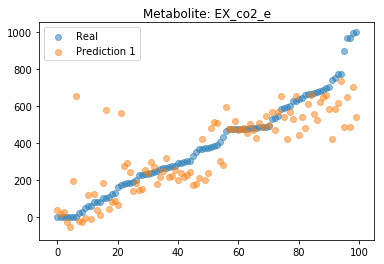

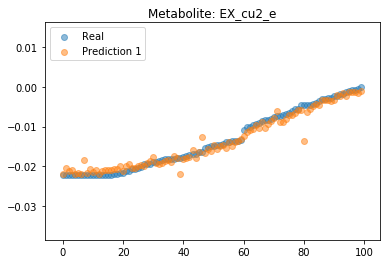

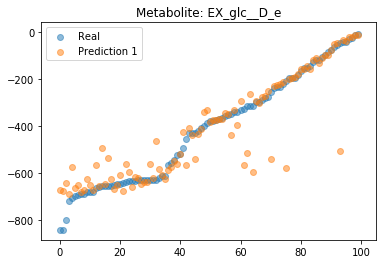

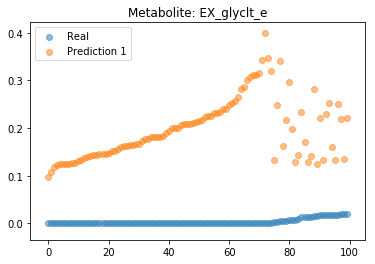

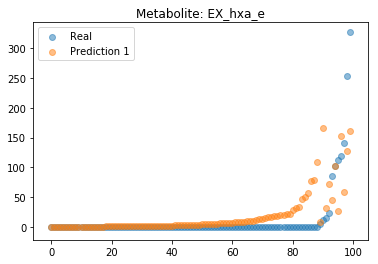

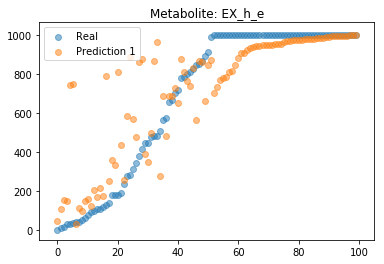

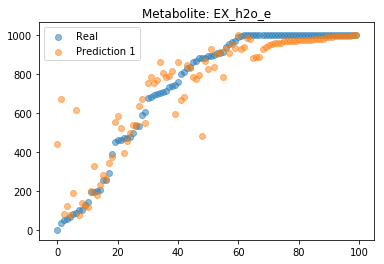

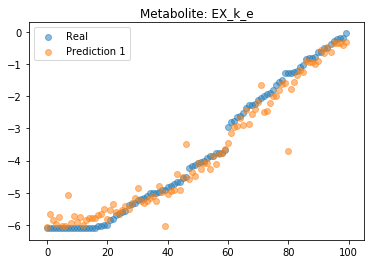

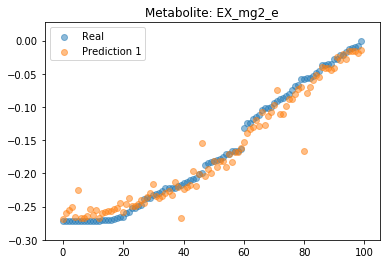

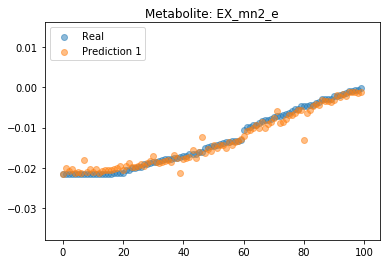

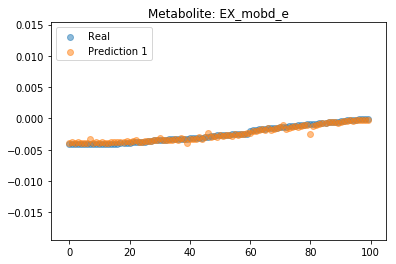

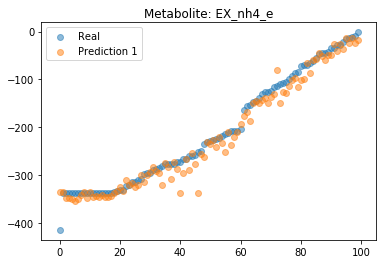

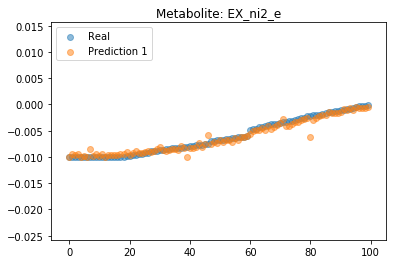

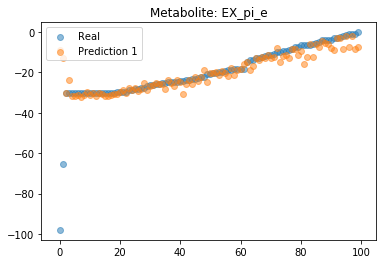

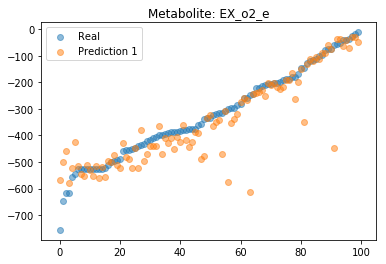

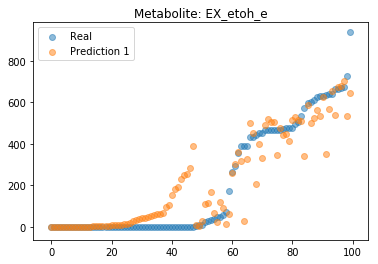

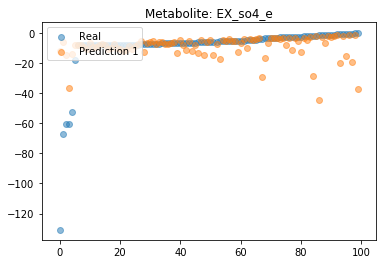

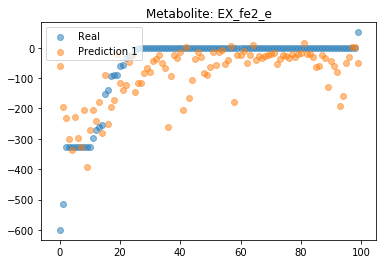

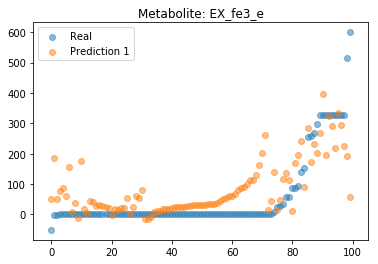

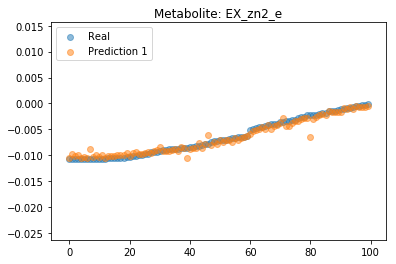

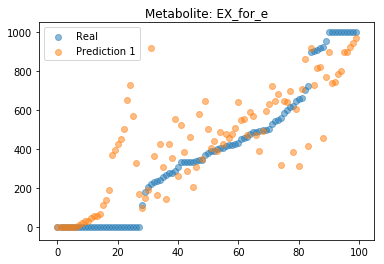

In [91]:
#Visualize the predictions vs the real values of some individuals for each output
n=200
for idx in range(outPreds.shape[1]):
    plot_prediction_comparison([outPreds[:n,idx]], ryTest[-1][:n,idx], glayersIds[-1][idx])

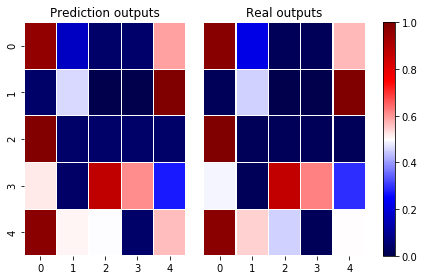

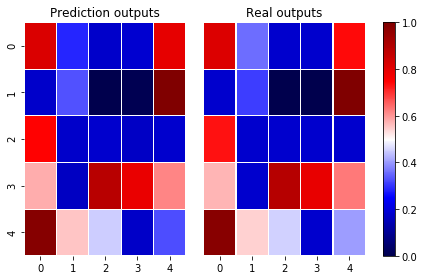

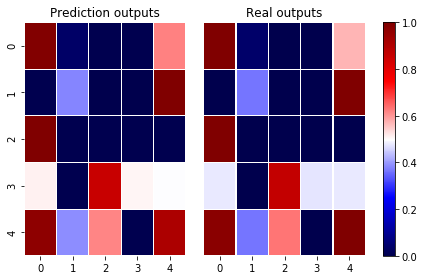

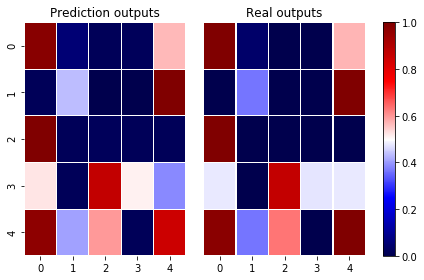

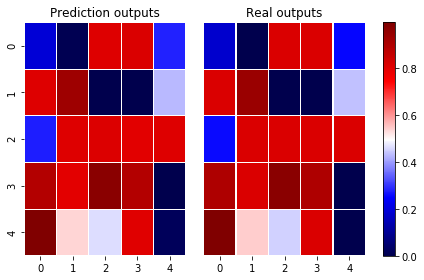

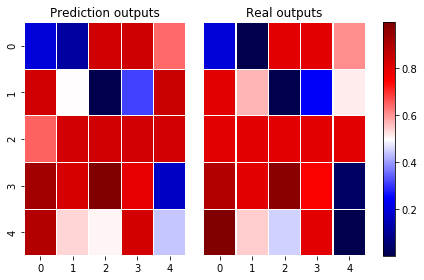

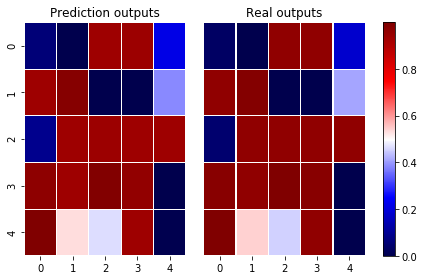

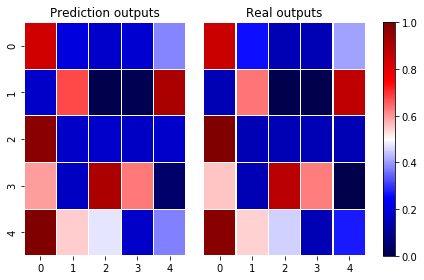

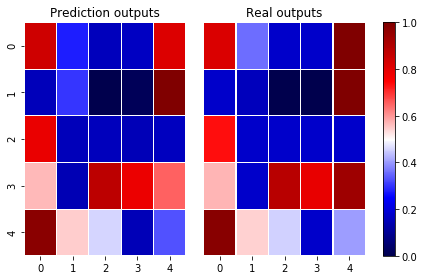

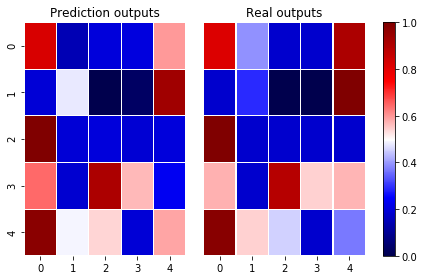

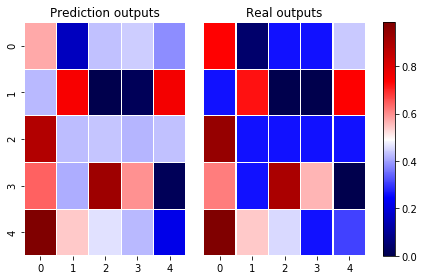

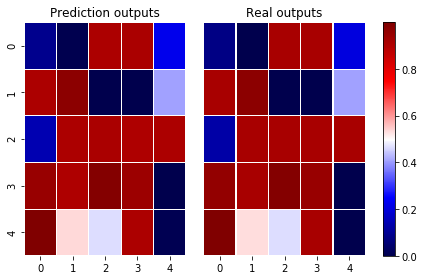

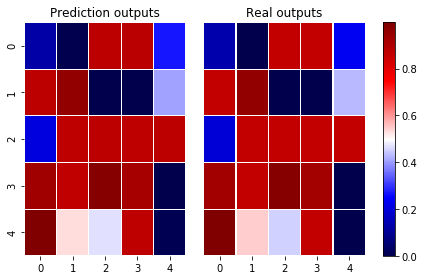

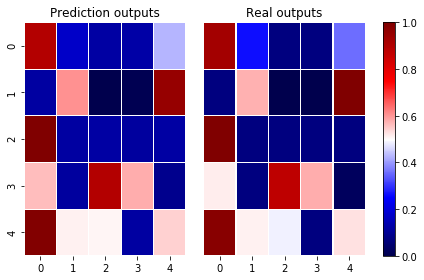

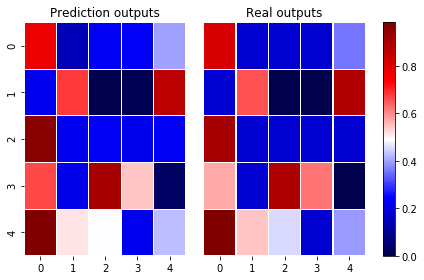

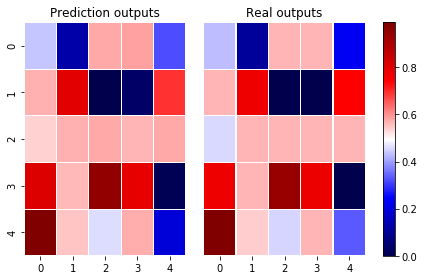

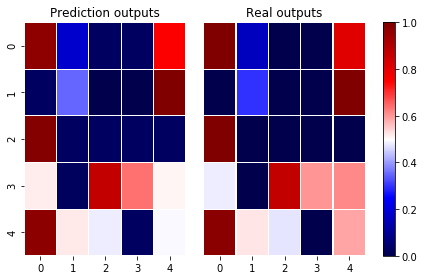

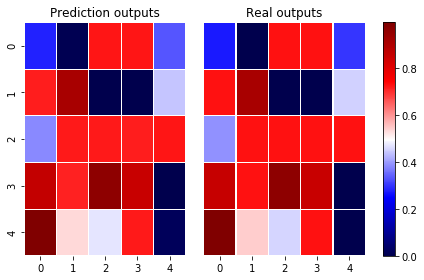

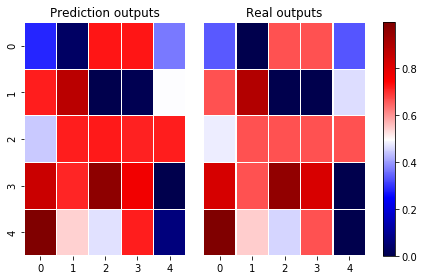

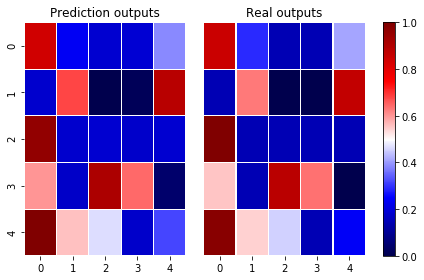

In [107]:
#Checking the real and predicted heatmaps of the outputs of several instances
for i in range(20):
    plotHeatmap(normOutPreds, yTest[-1], heatIdx=i, fillValue=0.5)#, save='outputsHeatmap.png')

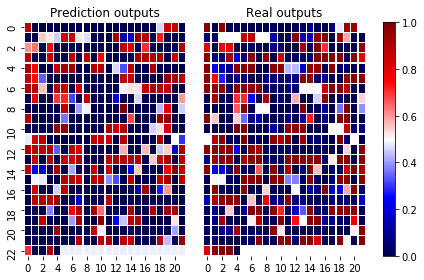

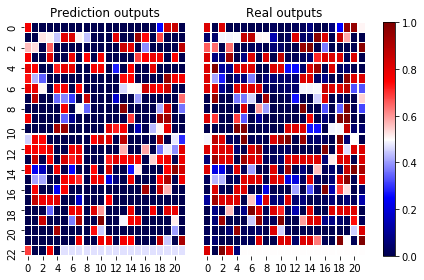

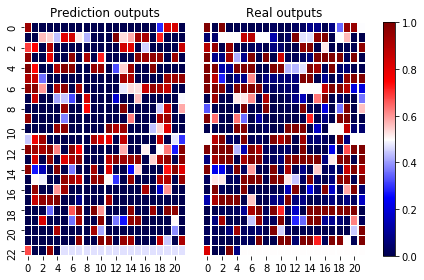

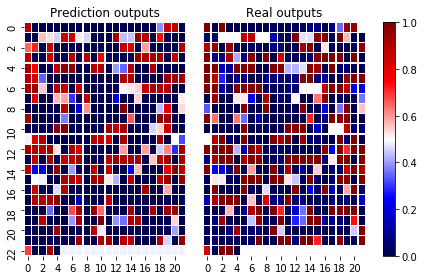

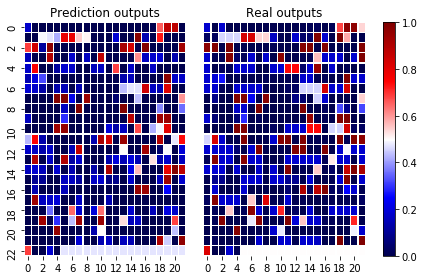

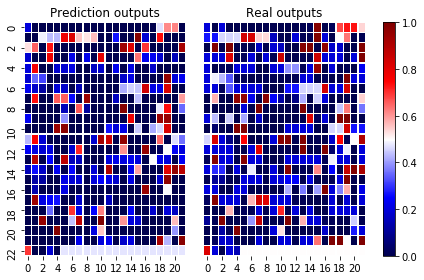

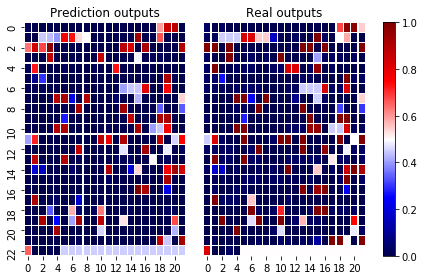

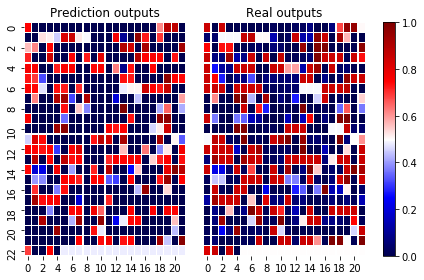

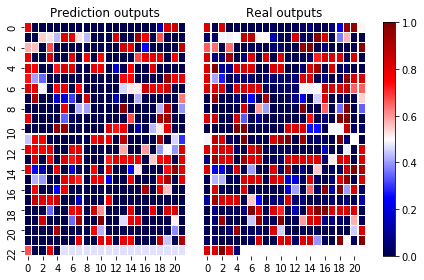

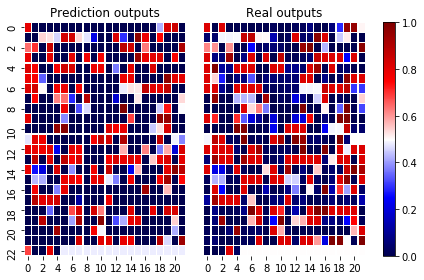

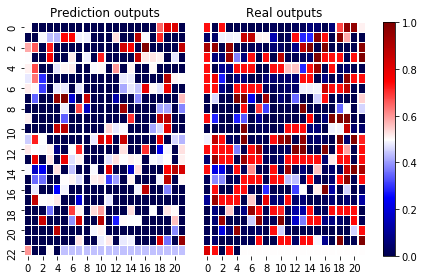

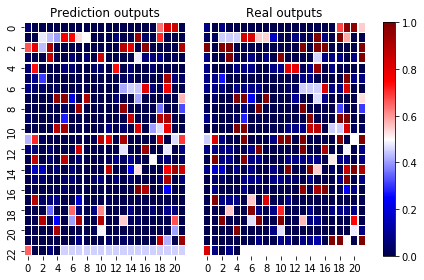

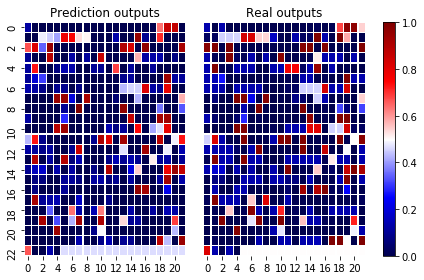

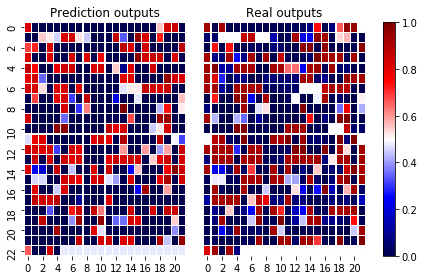

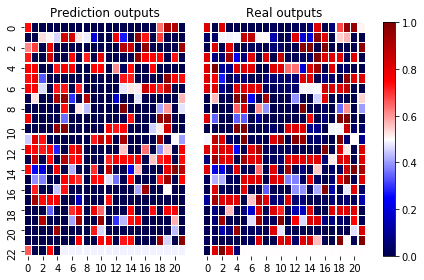

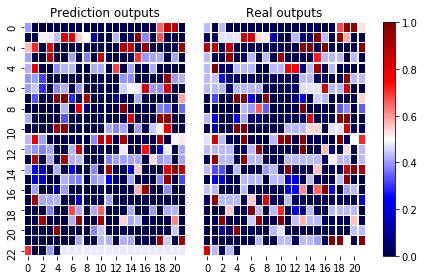

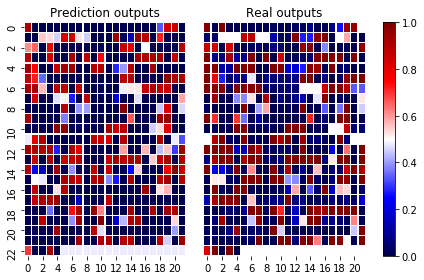

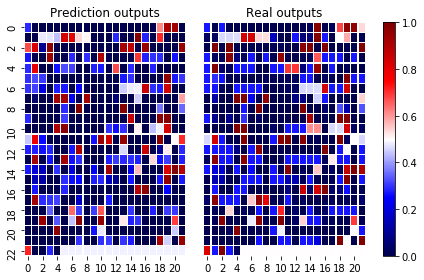

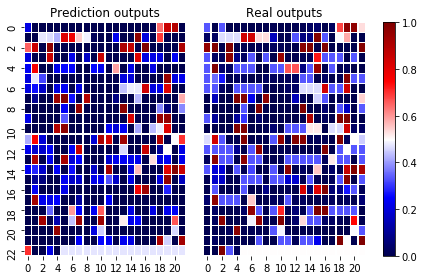

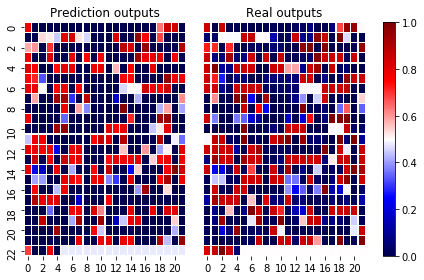

In [108]:
#Checking the real and predicted heatmaps of the inner reactions of several instances
for i in range(20):
    plotHeatmap(normReactPreds, yTest[0], heatIdx=i, fillValue=0.5)#, save='reactionsHeatmap.png')

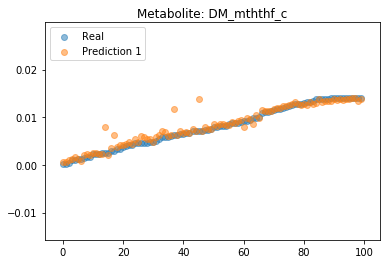

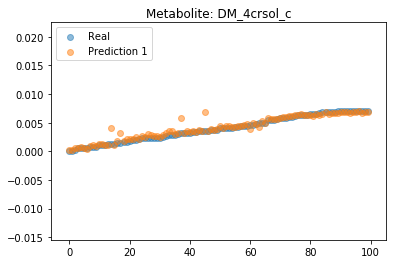

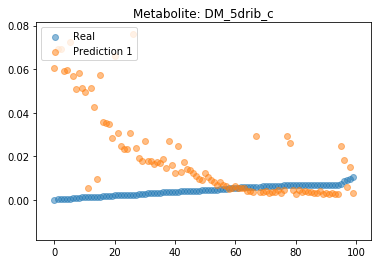

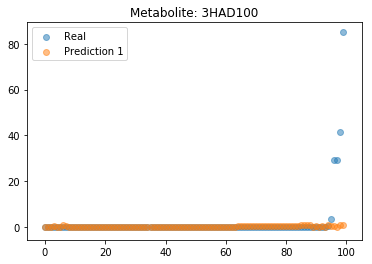

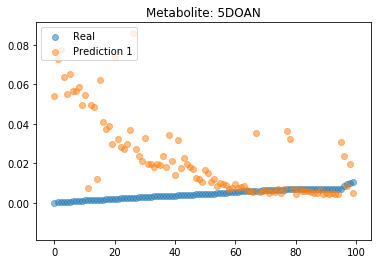

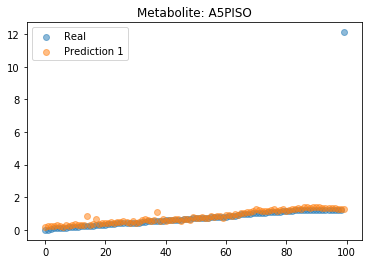

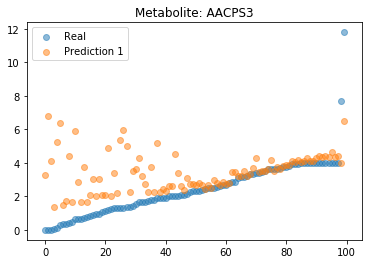

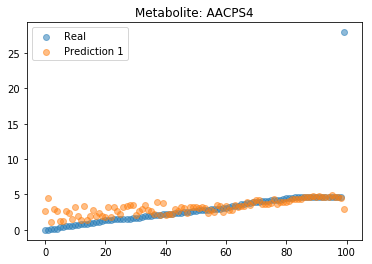

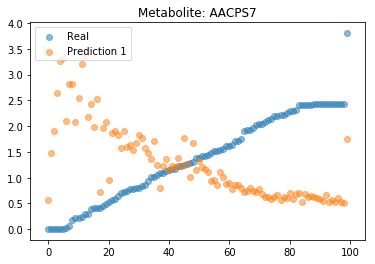

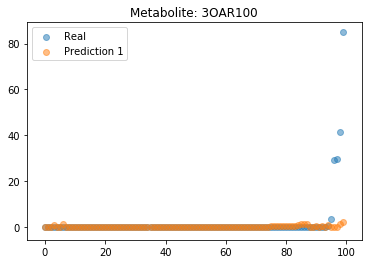

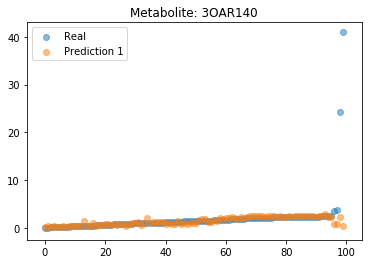

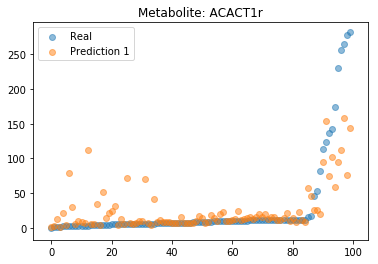

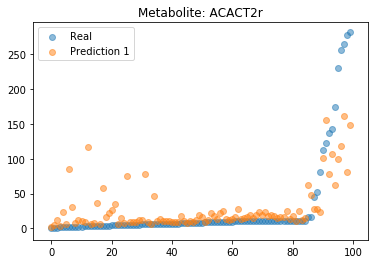

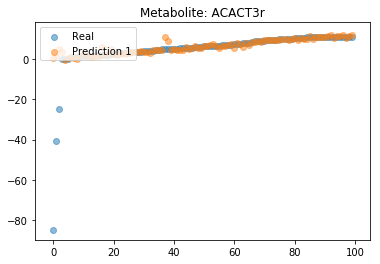

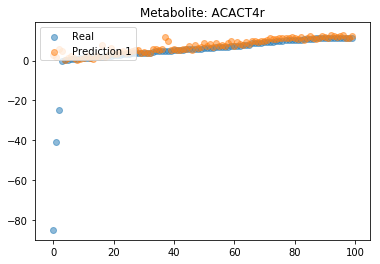

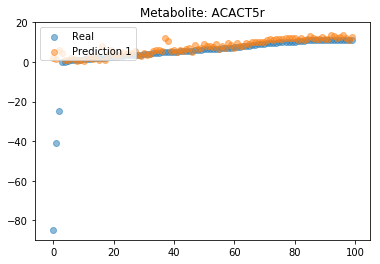

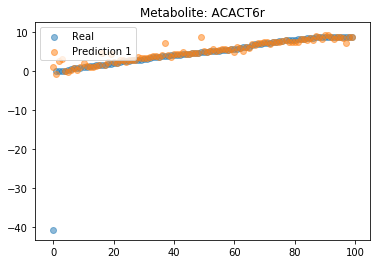

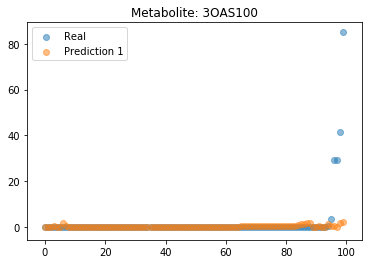

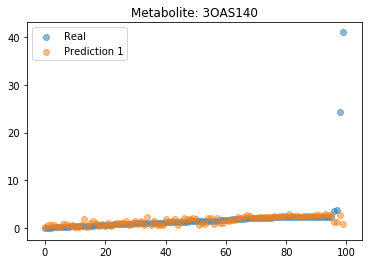

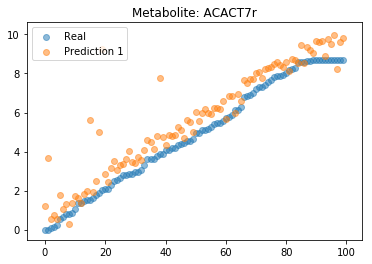

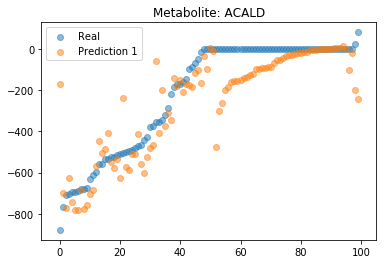

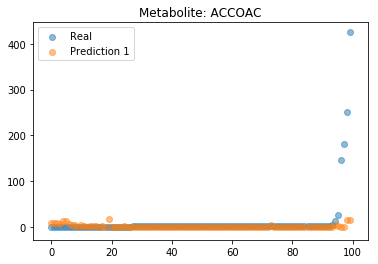

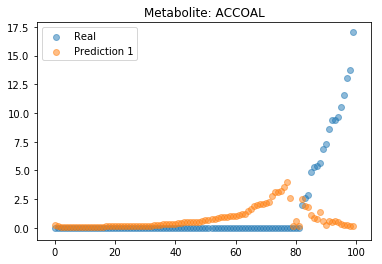

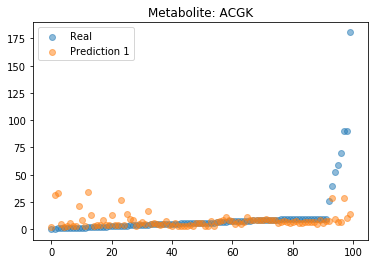

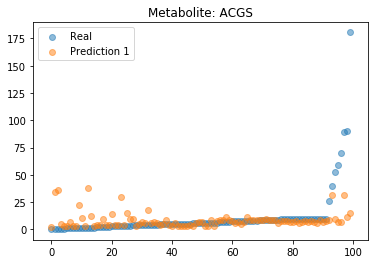

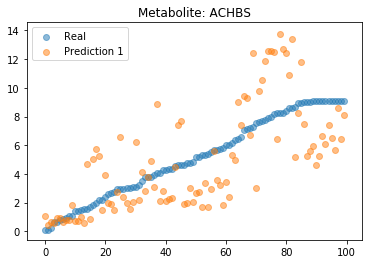

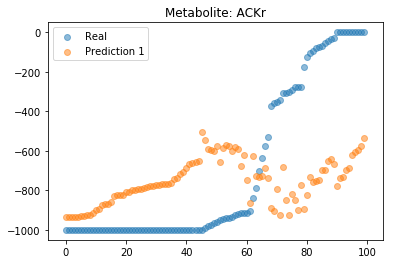

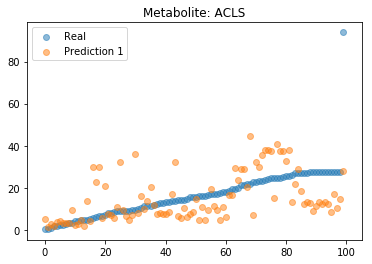

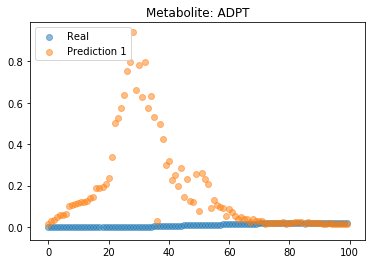

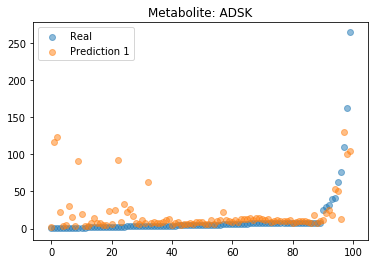

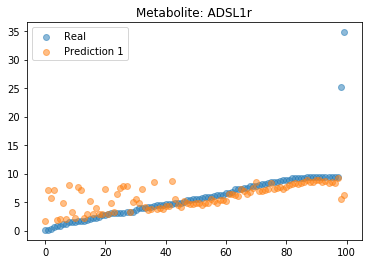

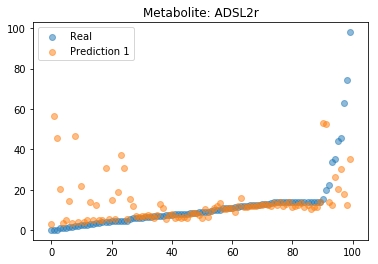

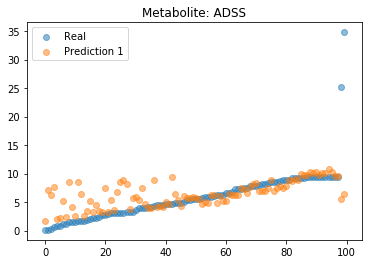

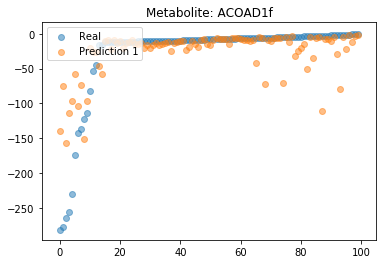

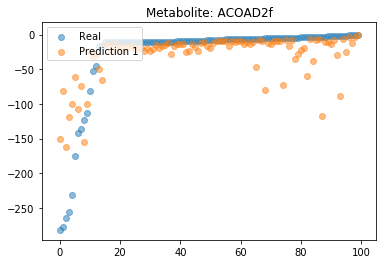

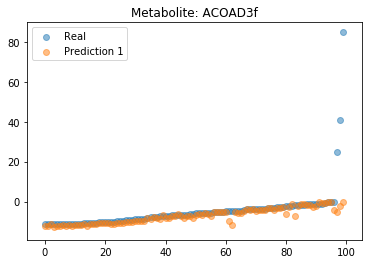

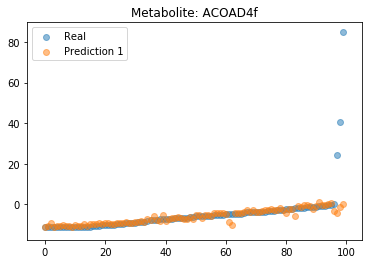

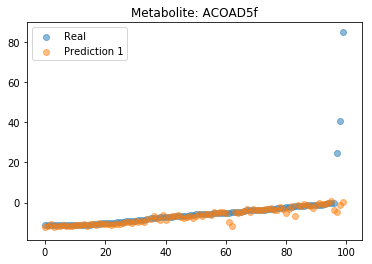

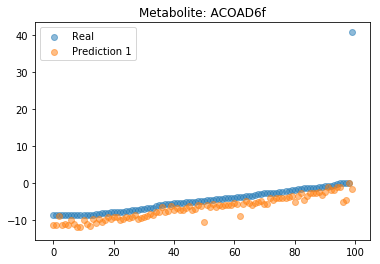

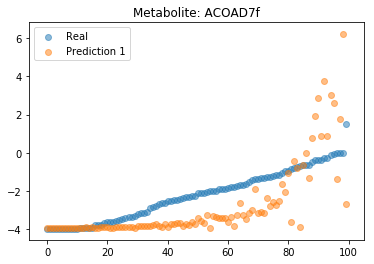

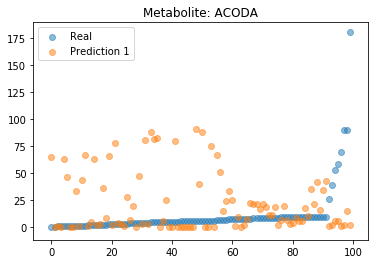

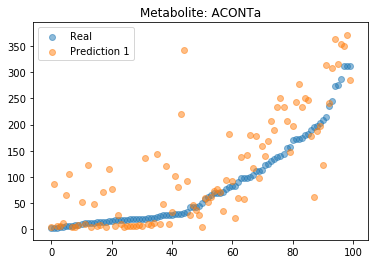

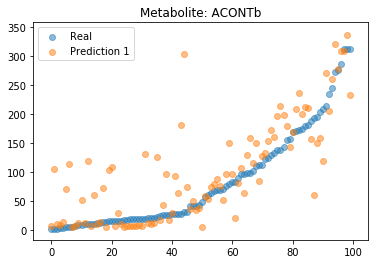

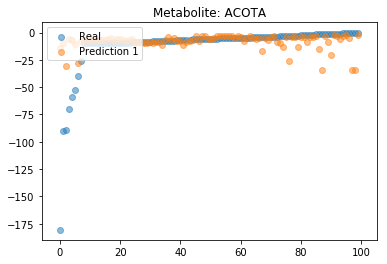

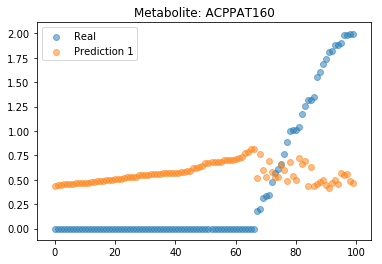

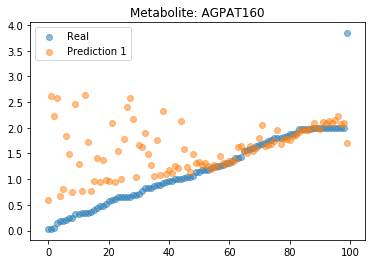

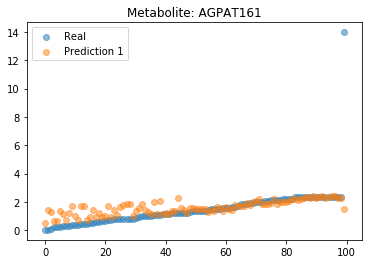

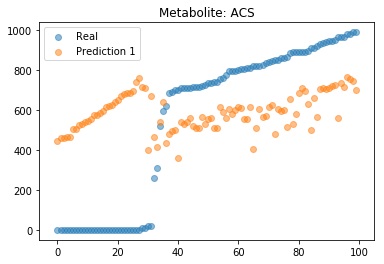

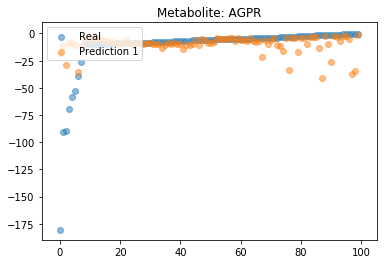

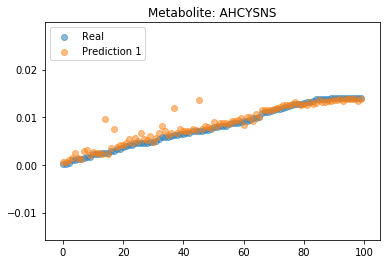

In [27]:
#Visualize the predictions vs the real values of some individuals for each output
n=100
for idx in range(50):#reactPreds.shape[1]):
    plot_prediction_comparison([reactPreds[:n,idx]], ryTest[-2][:n,idx], glayersIds[-2][idx])

In [37]:
bioIdx=biomassIndex(glayersIds[-1])
print('Biomass error: ',mean_absolute_error(outPreds[:,bioIdx], ryTest[-1][:,bioIdx]))

Biomass error:  1.6924185313473368


In [57]:
print(bioIdx)
print(glayersIds[-1])

0
['BIOMASS_Ec_iJO1366_core_53p95M' 'EX_cu2_e' 'EX_ac_e' 'EX_etoh_e'
 'EX_fe2_e' 'EX_fe3_e' 'EX_glyclt_e' 'EX_for_e' 'EX_ca2_e' 'EX_cl_e'
 'EX_co2_e' 'EX_glc__D_e' 'EX_h_e' 'EX_h2o_e' 'EX_pi_e' 'EX_so4_e'
 'EX_hxa_e' 'EX_zn2_e' 'EX_k_e' 'EX_mg2_e' 'EX_mn2_e' 'EX_mobd_e'
 'EX_nh4_e' 'EX_ni2_e' 'EX_o2_e']
